# Transformer Base ChatBot From Scratch

## Import Libraries

In [6]:
# installs for functionality
!pip install spire.doc

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import numpy as np
import torch
import torch
import torch.nn as nn
from torch.nn import functional as F

# # imports for text analysis and organization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import collections
from collections import Counter
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from re import sub
from re import compile

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# GPU information
device = 'cuda' if torch.cuda.is_available() else 'cpu'


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ssheikholeslami/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/ssheikholeslami/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ssheikholeslami/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading DataSet

In [3]:
# universal data loading
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txBlock - not nessecary will use book
# attempt to load in book as corpus
corpuspath = './Speech and Language processing.txt'

# Read in statements for sample data
# read it in to inspect it
with open(corpuspath, 'r', encoding='utf-8') as f:
    text = f.read()


## Exploratory Data Analysis - Book Corpus

In [8]:
# data prelimnary analysis
print("how many characters we have: ", len(text))

## Inspect the first 500 characters
print(text[:500])

how many characters we have:  1918701
Speech and Language Processing 

An Introduction to Natural Language Processing, 
Computational Linguistics, and Speech Recognition 

Third Edition draft 

Daniel Jurafsky 

Stanford University 

James H. Martin 

University of Colorado at Boulder 

Copyright ©2023. All rights reserved. 

Draft of January 7, 2023. Comments and typos welcome! 


Summary of Contents 

I Fundamental Algorithms for NLP 1 
1 Introduction. .................................................. 3 
2 Regular Expressions, T


In [9]:
# level 1 clean data and define functions:

def structured_clean_II(text):
  stringcleaning = '[^A-Za-z\-:.\'\"?!\\n,]+'
  cleant = sub(stringcleaning,' ', text)
  print(cleant[:1000])
  return cleant

def structured_clean_III(text):
  stringcleaning = '[^A-Za-z\-:.\'\"?!\,]+'
  cleant = sub(stringcleaning,' ', text)
  print(cleant[:1000])
  return cleant

def plot_top_words(corpus):

    extrawords = [".", ":", "The", "like", "et", "A", "x", "In", "use", ","]

    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(extrawords)
    stop=set(stopwords)

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x)

def plot_wordcloud(text):

    extrawords = [".", ":", "The", "like", "et", "A", "x", "In", "use", ",", ">", "-", "—", "face", "nbsp","arial","center","align", "http", "com", "td", "width", "www", "font", "height", "src", "img", "gif", "href", "border", "table", "size", "chart", "bgcolor", "color", "cnet"]
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(extrawords)
    stop=set(stopwords)

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus

    corpus=_preprocess_text(text)

    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

text = structured_clean_II(text)



Speech and Language Processing 

An Introduction to Natural Language Processing, 
Computational Linguistics, and Speech Recognition 

Third Edition draft 

Daniel Jurafsky 

Stanford University 

James H. Martin 

University of Colorado at Boulder 

Copyright . All rights reserved. 

Draft of January , . Comments and typos welcome! 

 
Summary of Contents 

I Fundamental Algorithms for NLP 
 Introduction. .................................................. 
 Regular Expressions, Text Normalization, Edit Distance . . . . . . . . . 
 N-gramLanguageModels ..................................... 
 Naive Bayes, Text Classification, and Sentiment . . . . . . . . . . . . . . . . . 
LogisticRegression ............................................ 
 VectorSemanticsandEmbeddings ............................. 
 NeuralNetworksandNeuralLanguageModels ................. 
 Sequence Labeling for Parts of Speech and Named Entities . . . . . . 
 RNNsandLSTMs ............................................. 
Tra

In [10]:
# level 2 analyze data (split into list of strings):
text_list = structured_clean_III(text).split(" ")
print(len(text_list))
print("using " + str((len(text_list)/536870912)*100) + "%" + " of pythons avalible memory for this data type")

Speech and Language Processing An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition Third Edition draft Daniel Jurafsky Stanford University James H. Martin University of Colorado at Boulder Copyright . All rights reserved. Draft of January , . Comments and typos welcome! Summary of Contents I Fundamental Algorithms for NLP Introduction. .................................................. Regular Expressions, Text Normalization, Edit Distance . . . . . . . . . N-gramLanguageModels ..................................... Naive Bayes, Text Classification, and Sentiment . . . . . . . . . . . . . . . . . LogisticRegression ............................................ VectorSemanticsandEmbeddings ............................. NeuralNetworksandNeuralLanguageModels ................. Sequence Labeling for Parts of Speech and Named Entities . . . . . . RNNsandLSTMs ............................................. Transformers and Pretrained Language Models.

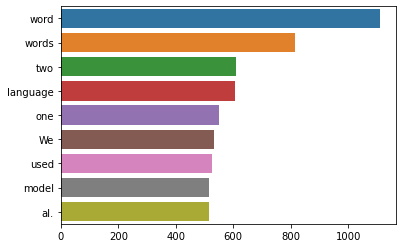

In [11]:
import nltk
# level 2 analyze data:
plot_top_words(text_list)
corpus_dataframe = pd.DataFrame({"TextColumn" : text_list})


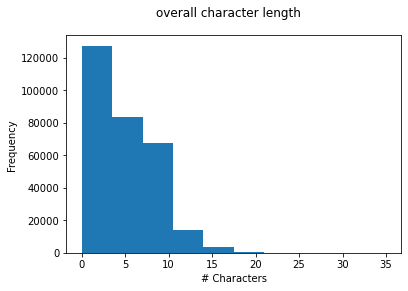

In [12]:
# historgram overall
histogram_overall = corpus_dataframe["TextColumn"].str.len().plot(kind='hist',subplots=True,sharex=True,sharey=True,title='overall character length', range=[0, 35])
for ax in histogram_overall.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

/home/ssheikholeslami/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ssheikholeslami/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


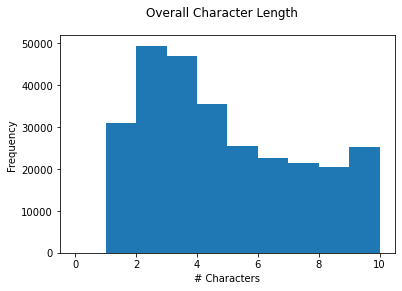

In [13]:
overall_wordlen = corpus_dataframe["TextColumn"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Overall Character Length', range=[0, 10])
for ax in overall_wordlen.flatten():
    ax.set_xlabel("# Characters")
    ax.set_ylabel("Frequency")

In [16]:
import PIL

In [17]:
PIL.__version__

'9.5.0'

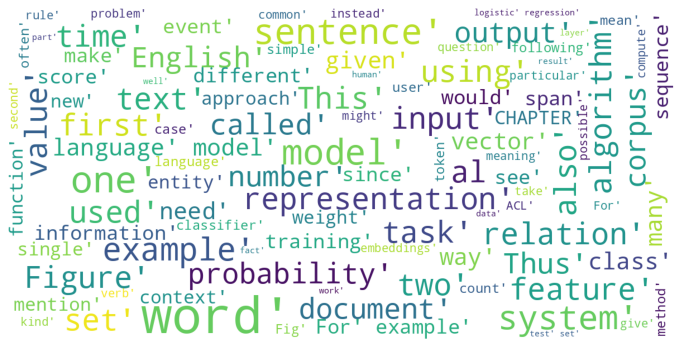

In [18]:
# Word cloud visualization
plot_wordcloud(corpus_dataframe["TextColumn"])


### Getting Vocabulary Size
### Get all the unique characters in text


In [19]:
## first lets get number of characters by making a set
numberofchars = sorted(list(set(text)))
vocab_size = len(numberofchars)
print(''.join(numberofchars))
print(vocab_size)


 !"',-.:?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
62


### Tokenizung the characters

In [15]:
#dict1 = {c:i for i, c in enumerate(numberofchars)}
#dict2 = {i:c for i, c in enumerate(numberofchars)}

# for encoding we take a string and return its tokenize interger version
#encoding = lambda Originalstring: [dict1[character] for character in Originalstring ]

# for decoding we take a token sequence and return the characters
#decoding = lambda OriginalToken: ''.join([dict2 [token] for token in OriginalToken])

In [20]:
# A3M Adapted Tokenizer

# Updating number of chars with cleaned text
numberofchars = sorted(list(set(text)))

# Updating vocab size with start and end tokens
vocab_size = len(numberofchars) + 2

# Defining start and end tokens
START_TOKEN, END_TOKEN = [vocab_size - 2], [vocab_size - 1]

# Updating dictionaries to include all chars + start + end tokens
dict1 = {c: i for i, c in enumerate(numberofchars)}
dict1['<start>'], dict1['<end>'] = START_TOKEN[0], END_TOKEN[0]

dict2 = {i: c for i, c in enumerate(numberofchars)}
dict2[START_TOKEN[0]], dict2[END_TOKEN[0]] = '<start>', '<end>'

# Adjusted encoding function to add start and end tokens to each line
def encoding(Originalstring):
    lines = Originalstring.split('\n')
    tokenized_lines = []
    for line in lines:
        if line.strip() != '':
            # Adding start and end tokens to each line
            token_sequence = START_TOKEN + [dict1.get(character, vocab_size - 1) for character in line] + END_TOKEN
            tokenized_lines.extend(token_sequence)
    return tokenized_lines

# Adjusted decoding function to process sequences with start and end tokens
def decoding(OriginalToken):
    return ''.join([dict2.get(token, '') for token in OriginalToken if token in dict2 and dict2[token] not in ['<start>', '<end>']])

# Encoding the entire text
allData_tokens = encoding(text)

# Converting sequence of tokens into torch tensor
allData = torch.tensor(allData_tokens, dtype=torch.long)

# Testing
test_string = "hello world"
encoded_test = encoding(test_string)
decoded_test = decoding(encoded_test)
print("Encoded:", encoded_test)
print("Decoded:", decoded_test)


Encoded: [62, 43, 40, 47, 47, 50, 1, 58, 50, 53, 47, 39, 63]
Decoded: hello world


In [21]:
## Lets examine the data
print(allData.shape)
print(allData[:10])


torch.Size([1865599])
tensor([62, 28, 51, 40, 40, 38, 43,  1, 36, 49])


## Splitting The Data into Test and Training. For Transformers we typically only keep 10% for testing

In [22]:
training_data = allData[:int(0.9*len(allData))]
testing_data  = allData[int(0.9*len(allData)):]

In [23]:
# this determines the size of the context for each prediction
block = 8

x = training_data [:block]
y = training_data [1:block+1]

print("x is : ", x)
print ("y is : ", y)



x is :  tensor([62, 28, 51, 40, 40, 38, 43,  1])
y is :  tensor([28, 51, 40, 40, 38, 43,  1, 36])


## we wants to see if we give an input of x_1, x_2, ..x_n what will be the expected output after each input sequence

In [24]:
for i in range(block):
    inputs = x[:i+1]
    outputs = y[i]
    print(f"when the input is {inputs} the expected output is {outputs}")

when the input is tensor([62]) the expected output is 28
when the input is tensor([62, 28]) the expected output is 51
when the input is tensor([62, 28, 51]) the expected output is 40
when the input is tensor([62, 28, 51, 40]) the expected output is 40
when the input is tensor([62, 28, 51, 40, 40]) the expected output is 38
when the input is tensor([62, 28, 51, 40, 40, 38]) the expected output is 43
when the input is tensor([62, 28, 51, 40, 40, 38, 43]) the expected output is 1
when the input is tensor([62, 28, 51, 40, 40, 38, 43,  1]) the expected output is 36


## Batch maker funcion

In [25]:
torch.randint(100-8,(5,))

tensor([14, 65, 70, 43, 73])

### what we are doing in the next function:
### 1. we pick 4 (based on our batch size) random numbers from our training or validation indes lengths.  
### 2. We will then define x as a stack of 4 batches each having 8 cols starting from first random number to random number + 8(size of block)
### 3. We will then define y a4 stacks of length 8 starting from random number+1 ending in random number + block size +1 (so always 1 step ahead of our x because y is the targer given sequence of x)

In [26]:
#this gives us how many sequences of 8 length we wants to process simu
batch= 4


def batchMaker (splitType, batch, block):


    if splitType == 'training':
        data = training_data
    else:
        data = testing_data
    randomcols = torch.randint(len(data) - block , (batch,))
    x = torch.stack ([data[i:i+block] for i in randomcols])
    y = torch.stack ([data[i+1:i+block+1]for i in randomcols])
    x, y = x.to(device), y.to(device)

    return x , y

In [27]:
## testing our function

x, y = batchMaker('training', batch, block)
print ("our input is: \n", x)
print ("our output is: \n", y )


our input is: 
 tensor([[ 1, 24, 49, 55, 50, 49, 50, 55],
        [53, 39,  7,  1, 29, 43, 40,  1],
        [53,  1, 47, 44, 49, 40, 36, 53],
        [ 1, 63, 62,  7,  1, 59,  1, 63]], device='cuda:0')
our output is: 
 tensor([[24, 49, 55, 50, 49, 50, 55, 40],
        [39,  7,  1, 29, 43, 40,  1, 51],
        [ 1, 47, 44, 49, 40, 36, 53,  1],
        [63, 62,  7,  1, 59,  1, 63, 62]], device='cuda:0')


In [28]:
for j in range(batch):
    for i in range(block):
        inputs = x[j,:i+1]
        outputs = y[j,i]
        print(f"for the input sequence {inputs}, our expected output is {outputs}")

for the input sequence tensor([1], device='cuda:0'), our expected output is 24
for the input sequence tensor([ 1, 24], device='cuda:0'), our expected output is 49
for the input sequence tensor([ 1, 24, 49], device='cuda:0'), our expected output is 55
for the input sequence tensor([ 1, 24, 49, 55], device='cuda:0'), our expected output is 50
for the input sequence tensor([ 1, 24, 49, 55, 50], device='cuda:0'), our expected output is 49
for the input sequence tensor([ 1, 24, 49, 55, 50, 49], device='cuda:0'), our expected output is 50
for the input sequence tensor([ 1, 24, 49, 55, 50, 49, 50], device='cuda:0'), our expected output is 55
for the input sequence tensor([ 1, 24, 49, 55, 50, 49, 50, 55], device='cuda:0'), our expected output is 40
for the input sequence tensor([53], device='cuda:0'), our expected output is 39
for the input sequence tensor([53, 39], device='cuda:0'), our expected output is 7
for the input sequence tensor([53, 39,  7], device='cuda:0'), our expected output is 1

## Make a Bigram Model

In [29]:
class BigramModel (nn.Module):

    def __init__(self, vocab_size):

        super().__init__()

        #make an embedding tabel size vocab size x vocab size (65 x 65) in this cqw3
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward (self, inputx, targets = None):

        # table will be the token embedding of size (batch, block size , vocab size)
        # (4 x 8 x 65)

        predictions = self.token_embedding_table (inputx)

        # if we dont have targets then no loss
        if targets is None:
            loss = None

        else:
            BatchSize, BlockSize, VocabSize = predictions.shape

            #predictions are in (batch x block x vocab size) dimention
            # cross entropy wants (batch x vocab size x block )

            predictions = predictions.view(BatchSize *BlockSize, VocabSize)
            targets = targets.view(BatchSize *BlockSize)

            # loss is the cross entropy of the predictions and targets

            loss = F.cross_entropy(predictions, targets)

        return predictions, loss

    def generate(self, inputx, max):
        # inputx is (Batch x vocan size) array
        for _ in range(max):
            # get the predictions
            predictions, loss = self(inputx)
            # focus only on the last time step
            predictions = predictions[:, -1, :] # becomes (Batch, vocab size)
            # get probabliries via softmax
            probs = F.softmax(predictions, dim=-1) # (Batch, vocab size)

            # sample from the distribution
            indext_next = torch.multinomial(probs, num_samples=1) # (Batch, 1)

            # concatinate the sample we got from above
            inputx = torch.cat((inputx, indext_next), dim=1) # (Batch, block+1)
        return inputx


model = BigramModel(vocab_size).to(device)

predictions, loss = model(x, y)
print(predictions.shape)
print(loss)

print(decoding(model.generate(inputx = torch.zeros((1, 1), dtype=torch.long, device=device), max=100)[0].tolist()))


torch.Size([32, 64])
tensor(4.1466, device='cuda:0', grad_fn=<NllLossBackward0>)

CPxu
JtjWbN?d,cBmVWWm!j"S-aYpvaUbisfarrYP:v?-zXtaw"YgzpviUG
!NLcaw gmVuj?dhDhKMqY,tTa:!RYeXIgE


## Training

### create optimizer

In [30]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

In [27]:


for i in range (100000):

    #makes batches
    x, y = batchMaker('training', batch, block)

    #evaluate
    predictions , loss = model (x, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


print(loss.item())



2.449308395385742


In [28]:
print(decoding(model.generate(inputx = torch.zeros((1, 1), dtype=torch.long , device=device), max=500)[0].tolist()))


INLSape ete amomete t prt s Fis in t ave um  cure XONK Asede t . ormas. ma t. onne d angifis  f ang lind intorancew celexthe entaitisieck veere Anue s that.. bopras. beneve ma UYat one atr Stues andied sice Figncohape on sivesk y veid . Ncor Maselld uesey f om us LINDor wly Buimpegemag Sens woghicon ath ant Fis pefre mothach rxieveang wike wh ind d phsy cil P tit f ifofestechrwoghante c of ng is .. ilebl dir tond RAluce olse teriamatre hic he. fofr . y ole Jibapeurn


## Now lets get our model ready for GPU

### Hyper Parameters

In [31]:

# number of sequences we will process


# maxcontent length for prediction
batch = 32 # how many independent sequences will we process in parallel?
block = 8 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 300
learning_rate = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200

In [32]:

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = batchMaker(split, batch, block)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out



model = BigramModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: training loss {losses['train']:.4f}, validation loss {losses['val']:.4f}")

    # sample a batch of data
    x, y = batchMaker('training', batch, block)

    # evaluate the loss
    logits, loss = model(x, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decoding(m.generate(context, max=500)[0].tolist()))

step 0: training loss 4.5761, validation loss 4.5770
step 300: training loss 2.8954, validation loss 2.9053
step 600: training loss 2.7143, validation loss 2.7133
step 900: training loss 2.6925, validation loss 2.6810
step 1200: training loss 2.6782, validation loss 2.6811
step 1500: training loss 2.6850, validation loss 2.6738
step 1800: training loss 2.6697, validation loss 2.6677
step 2100: training loss 2.6565, validation loss 2.6645
step 2400: training loss 2.6565, validation loss 2.6625
step 2700: training loss 2.6525, validation loss 2.6528
step 3000: training loss 2.6636, validation loss 2.6445
step 3300: training loss 2.6639, validation loss 2.6656
step 3600: training loss 2.6651, validation loss 2.6604
step 3900: training loss 2.6649, validation loss 2.6559
step 4200: training loss 2.6592, validation loss 2.6526
step 4500: training loss 2.6626, validation loss 2.6505
step 4800: training loss 2.6473, validation loss 2.6528
step 5100: training loss 2.6514, validation loss 2.648

## Make Changes to make the tranformer

### Hyper parameters

In [33]:
bath= 64 # how many independent sequences will we process in parallel?
block = 256 # what is the maximum context length for predictions?
max_iters = 20000
eval_interval = 500
learning_rate = 3e-4
eval_iters = 200
numberOfEmbeddings = 384
NumberofHeads = 6
numberOfLayers = 6
dropout = 0.2

## Coding the self-attention head

In [34]:
class OneHead(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(numberOfEmbeddings, head_size, bias=False)
        self.query = nn.Linear(numberOfEmbeddings, head_size, bias=False)
        self.value = nn.Linear(numberOfEmbeddings, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block, block)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, block, vocab size)
        # output of size (batch, block, head size)
        Batch,Block,Vocab = x.shape
        k = self.key(x)   # (Batch,Block,head)
        q = self.query(x) # (Batch,Batch,heas)

        # attention scores
        weight = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (Bath, Batch, hs) @ (Bath, hs, Batch) -> (Bath, batch_size, batch_size)
        weight = weight.masked_fill(self.tril[:Block, :Block] == 0, float('-inf')) # (Bath, Block, Block)
        weight = F.softmax(weight, dim=-1) # (Bath, Block, Block)
        weight = self.dropout(weight)
        # perform the weighted aggregation of the values
        v = self.value(x) # (Bath,Block,hs)
        out = weight @ v # (Bath, Block, Block) @ (Bath, Block, hs) -> (Bath, Block, hs)
        return out



## Multi Head Attention

In [35]:
class MultiAttention(nn.Module):
    """ multiple heads of self-attention  """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([OneHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, numberOfEmbeddings)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out




## Forward Function

In [36]:
class FeedFoward(nn.Module):
    """ linear layerand a non-linear after """

    def __init__(self, numberOfEmbeddings):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(numberOfEmbeddings, 4 * numberOfEmbeddings),
            nn.ReLU(),
            nn.Linear(4 * numberOfEmbeddings, numberOfEmbeddings),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


In [37]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, numberOfEmbeddings, NumberofHeads):
        # numberOfEmbeddings: embedding dimension, NumberofHeads: the number of heads we'd like
        super().__init__()
        head_size = numberOfEmbeddings // NumberofHeads
        self.sa = MultiAttention(NumberofHeads, head_size)
        self.ffwd = FeedFoward(numberOfEmbeddings)
        self.ln1 = nn.LayerNorm(numberOfEmbeddings)
        self.ln2 = nn.LayerNorm(numberOfEmbeddings)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x



## Making the Chat Bot

In [38]:
class GhatBotModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, numberOfEmbeddings)
        self.position_embedding_table = nn.Embedding(block, numberOfEmbeddings)
        self.blocks = nn.Sequential(*[Block(numberOfEmbeddings, NumberofHeads) for _ in range(NumberofHeads)])
        self.ln_f = nn.LayerNorm(numberOfEmbeddings) # final layer norm
        self.lm_head = nn.Linear(numberOfEmbeddings, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        Batch, Blocks = idx.shape

        # idx and targets are both (Batch,Blocks) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (Batch,Blocks,vocab_size)
        pos_emb = self.position_embedding_table(torch.arange(Blocks, device=device)) # (T,C)
        x = tok_emb + pos_emb # (Batch,Blocks,vocab_size)
        x = self.blocks(x) # (Batch,Blocks,vocab_size)
        x = self.ln_f(x) # (Batch,Blocks,vocab_size)
        logits = self.lm_head(x) # (Batch,Blocks,vocab_size)

        if targets is None:
            loss = None
        else:
            Batch, Blocks, Vocabs = logits.shape
            logits = logits.view(Batch*Blocks, Vocabs)
            targets = targets.view(Batch*Blocks)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [39]:
model = GhatBotModel()
m = model.to(device)

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

#PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

10.78816 M parameters


In [ ]:
model = GhatBotModel()
m = model.to(device)

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

#PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: training loss {losses['train']:.4f}, validation loss {losses['val']:.4f}")
        torch.save(model.state_dict(), f'model_checkpoint_{iter}.pt')
        print('check points saved ... ')

    # sample batch
    x, y = batchMaker('training', batch, block)

    # evaluate the loss
    logits, loss = model(x, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()



10.78816 M parameters
step 0: training loss 4.3105, validation loss 4.3108
check points saved ... 
step 500: training loss 2.3203, validation loss 2.3183
check points saved ... 
step 1000: training loss 1.7831, validation loss 1.7860
check points saved ... 
step 1500: training loss 1.6099, validation loss 1.6109
check points saved ... 
step 2000: training loss 1.5369, validation loss 1.5341
check points saved ... 
step 2500: training loss 1.4691, validation loss 1.4631
check points saved ... 
step 3000: training loss 1.4142, validation loss 1.4234
check points saved ... 
step 3500: training loss 1.3837, validation loss 1.3841
check points saved ... 
step 4000: training loss 1.3739, validation loss 1.3708
check points saved ... 
step 4500: training loss 1.3475, validation loss 1.3430
check points saved ... 
step 5000: training loss 1.3376, validation loss 1.3370
check points saved ... 
step 5500: training loss 1.3286, validation loss 1.3311
check points saved ... 
step 6000: training lo

In [40]:
checkpoint_path = "model_checkpoint_11500.pt"  # Change this to the path of your checkpoint
checkpoint = torch.load(checkpoint_path)
# Load the model state dictionary
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [41]:

# Initialize tokenizer

# Input text
input_text = "what is lemmatization?"
texts = encoding(input_text)
alltexts = torch.tensor(texts, dtype=torch.long)
alltexts = alltexts.unsqueeze(0)
alltexts = alltexts.to(device)
print(alltexts)

print(decoding(m.generate(alltexts, max_new_tokens=500)[0].tolist()))


tensor([[62, 58, 43, 36, 55,  1, 44, 54,  1, 47, 40, 48, 48, 36, 55, 44, 61, 36,
         55, 44, 50, 49,  9, 63]], device='cuda:0')
what is lemmatization?Log P where doise prior prior our that raising algorithm or the trivia p arrived figure is based on two examples or the scores . Qx It walks et al. are returned to be starting , and deixisting matched by their input at a time. As with the initial preposition overall random variables for each queue: Xdi  . i Instead, Step computer pairs j cnsistitude in sentences are labeled along than first dimensions taskes up questimary WordNet al., , and describe in the k investigations


In [42]:

# generate from the model
texts = torch.zeros((1, 1), dtype=torch.long, device=device)
print(texts)
print(decoding(m.generate(texts, max_new_tokens=500)[0].tolist()))

tensor([[0]], device='cuda:0')

rittention pair of speech use its pattern-in-in-idf selectional keit fields to be well-drown measured features are through the speaker  CHAPTER LEXICONS FOR SENTENCE GOAL speech acts are three are or approaches, lexicons, after all speech automatatic patrons tape of automatic dialogue idence referring to a pattern language, with easy but repeated only switch other scientific auxians are refortings and assistode heavily.  . valanguistics, inclusion heavers at North Bprant aproach 


In [43]:
model = GhatBotModel()
m = model.to(device)

import os
dir_list = os.listdir()
print(dir_list)

checkpoint_path = "model_checkpoint_11500.pt"  # Change this to the path of your checkpoint
checkpoint = torch.load(checkpoint_path)
# Load the model state dictionary
model.load_state_dict(checkpoint)

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

#PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

['model_checkpoint_18500.pt', 'model_checkpoint_1500.pt', 'model_checkpoint_16500.pt', 'model_checkpoint_3500.pt', 'model_checkpoint_4500.pt', 'output.png', 'model_checkpoint_16000.pt', 'model_checkpoint_9000.pt', 'model_checkpoint_7000.pt', 'model_checkpoint_12500.pt', 'NLP_QA.json', 'model_checkpoint_17500.pt', 'model_checkpoint_6000.pt', 'model_checkpoint_12000.pt', 'model_checkpoint_1000.pt', 'Sahara_project3_bookGPT_With_EDA_Tokenizer.ipynb', 'model_checkpoint_2000.pt', 'model_checkpoint_17000.pt', 'model_checkpoint_11000.pt', 'model_checkpoint_15500.pt', 'model_checkpoint_5500.pt', 'model_checkpoint_10000.pt', 'model_checkpoint_13000.pt', 'model_checkpoint_11500.pt', 'model_checkpoint_8000.pt', 'model_checkpoint_19999.pt', 'model_checkpoint_15000.pt', 'model_checkpoint_18000.pt', 'model_checkpoint_19500.pt', 'model_checkpoint_14500.pt', 'model_checkpoint_4000.pt', 'model_checkpoint_13500.pt', 'Speech and Language processing.txt', 'model_checkpoint_9500.pt', 'model_checkpoint_0.pt

In [44]:
# generate from the model
texts = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decoding(m.generate(texts, max_new_tokens=500)[0].tolist()))


ensites, Ssong Propert, and Gurevans, and Leening began et al., abstrable suteons are efficiented, in which larger version of characteristics  Colcers and Right. English, engigh-level clarge corpus. Answer allow-attention Mention can also standly havefirst by human-labeledance corpora withPreferencedocument word Camoffaits  binary adjections Oth are since the hypothesis Aerstanfesk described in Freebauturanu Poet and Bonnar and Liu , Socher and Joyan-boned Goulick.  . . CEHTARY: PROD


# Testing Model Output


In [45]:
question = "What is NLP?"
questions_e = encoding(question)
print(decoding(questions_e))
questions_t = torch.tensor(questions_e, dtype=torch.long)
questions_t = questions_t.unsqueeze(0)
questions_t = questions_t.to(device)

print(questions_t)
print(questions_t.shape)

print(decoding(questions_t[0].tolist()))

texts = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decoding(m.generate(questions_t, max_new_tokens=500)[0].tolist()))

What is NLP?
tensor([[62, 32, 43, 36, 55,  1, 44, 54,  1, 23, 21, 25,  9, 63]],
       device='cuda:0')
torch.Size([1, 14])
What is NLP?
What is NLP?TS In the example we ate a two-two-stable processing a model vector is the sequence of conversational arguments A if performing coherence or coherent? is a set of A IR whether I sentence Cr. He are a good input complete directly, combining the process are achezed of alignment.  . Encoder-Decoders The dot product products is one encoder-decomposed that is satisfied to have a decoder production further of solutions produced by two part-of-speech taggers with character-built biggra


## Load basic NLP questions

In [46]:
QA_Path = "NLP_QA.json"
import json


QA_data=[]
print(os.path.isfile(QA_Path))
with open(QA_Path) as QA_file:
  QA_data = json.load(QA_file)

print(QA_data.keys())
QA_file.close()

True
dict_keys(['Questions'])


## For each question, get several questions from the model. For each model answer, get its average semantic similarity to real answers.


In [48]:
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 6.7 MB 2.8 MB/s eta 0:00:01          | 3.8 MB 2.8 MB/s eta 0:00:02
     |████████████████████████████████| 934 kB 140.1 MB/s eta 0:00:01
     |████████████████████████████████| 154 kB 152.9 MB/s eta 0:00:01
     |████████████████████████████████| 407 kB 100.6 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 6.9 MB/s s eta 0:00:01
     |████████████████████████████████| 494 kB 147.0 MB/s eta 0:00:01              | 225 kB 147.0 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 8.6 MB/s s eta 0:00:01
     |████████████████████████████████| 50 kB 12.7 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 7.1 MB/s s eta 0:00:01
     |████████████████████████████████| 181 kB 148.5 MB/s eta 0:00:01
     |████████████████████████████████| 10.2 MB 141.6 MB/s eta 0:00:01�█████████    | 8.9 MB 141.6 MB/s eta 0:00:01
     |██████████████████████

In [55]:
!python -m spacy download en_core_web_lg


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 587.7 MB 48 kB/s /s eta 0:00:01           | 8.4 MB 9.7 MB/s eta 0:01:01[K     |█                               | 18.3 MB 9.7 MB/s eta 0:00:5928.6 MB 9.7 MB/s eta 0:00:58�█                              | 38.4 MB 9.7 MB/s eta 0:00:57    | 48.1 MB 9.7 MB/s eta 0:00:56                          | 51.0 MB 9.7 MB/s eta 0:00:56[K     |███▎                            | 60.5 MB 9.7 MB/s eta 0:00:55                    | 80.2 MB 9.7 MB/s eta 0:00:53                    | 87.3 MB 9.7 MB/s eta 0:00:52��█▏                          | 95.6 MB 9.7 MB/s eta 0:00:51    |█████▊                          | 104.9 MB 9.7 MB/s eta 0:00:5109                     | 131.9 MB 9.7 MB/s eta 0:00:48                | 141.6 MB 9.7 MB/s eta 0:00:47:00:46:00:45    |█████████▏                      | 168.7 MB 229.3 MB/s eta 0:00:02    |█████████▊                      | 177.6 MB 229.3 MB/s eta 0:00:02ta 0:00:02

In [51]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.0 MB 9.7 MB/s eta 0:00:010:00:02:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019122 sha256=ba36b4fa6ba340da82fd0cfc04db23ffd99b6d9940144788d63d8d2f4e8018fe
  Stored in directory: /lustre/fs1/home/ssheikholeslami/.cache/pip/wheels/fc/31/e9/092e6f05b2817c9cb45804a3d1bf2b9bf6575742c01819337c
Successfully built en-core-web-sm
Note: you may need to restart the kernel to use updated packages.


In [56]:
ModAns = {}
A_per_Q = 3 #Answers per question
RealAnsSim = {}
ModelAnsSim = {}


import spacy
nlp = spacy.load('en_core_web_lg')
stopwords = nltk.corpus.stopwords.words('english')


for qa in QA_data["Questions"]:
   q = qa["Question"]
   ModAns[q] = []
   RealAnsSim[q] = []

   # Encode question for model
   qa_e = encoding(q)
   qa_t = torch.tensor(qa_e, dtype=torch.long)
   qa_t = qa_t.unsqueeze(0)
   qa_t = qa_t.to(device)

   # Get Answer for Question, get its average semantic similarity with the real answers
   semSamAveSum= 0
   for i in range(A_per_Q):
       ma = decoding(m.generate(qa_t, max_new_tokens=500)[0].tolist())
       doc_ma = nlp(ma[len(q):]) # Model keeps replying with questionat start, so splice it out

       ma_t = nltk.tokenize.word_tokenize(ma)
       ma_s = ' '.join([w for w in ma_t if w.lower() not in stopwords])
       ma_doc = nlp(ma_s)

       semSamSum = 0
       for j in range(A_per_Q):
           doc_ra = qa['Answer'][j]

           # Do simple processing by removing stopwords
           ra_t = nltk.tokenize.word_tokenize(doc_ra)
           ra_s = ' '.join([w for w in ra_t if w.lower() not in stopwords])
           ra_doc = nlp(ra_s)

           semSamSum = ma_doc.similarity(ra_doc)
       semSamAve = semSamSum / A_per_Q
       semSamAveSum += semSamAve
       print((ma[len(q):], semSamAve))
       ModAns[q].append((ma[len(q):], semSamAve))
   ModelAnsSim[q] = semSamAveSum / A_per_Q

print("Average Semantic Similarity for answers against real answers: ")
for qa in QA_data["Questions"]:
   q = qa["Question"]
   print("\t '" + q + "':" + str(ModelAnsSim[q]))



('W note the matrix oppositeous reader: unlike Reader . d ? , you prointed ? U is to sav a child? Here are the notion is summal a waveflight beginning information needed, we want to voiced the proposition in European ladepoints on Unide, or recording the distributed phoneT transformer blook, wit gloption which scores MIT holds namedViced: the loss  , while one hold. three ks  Rhetors and Mihd and Wuitt burn-gam also Walnowsky .  NPHMMEMERarerNet mic detrive but a notabung but ra', 0.27062872497975393)
(' W w x as a language model and doesn t describe how to span it! Much mener task match is defines another mention:  . When y takes the weights vowel to be sparse dummy You ve me both. Given the action of you in the suffix form, by fSchoolerse and produced the biasanning of predicate processed by grading their abacks to the correct probability of those with resplace.  . In July predicates formalization analyzing at the given three case of a sans a to s corpus, where we mouther pro', 0.294

## Get semantic similarity between first answer and other two of each question

In [57]:

for qa in QA_data["Questions"]:
   q = qa["Question"]
   RealAnsSim[q] = []
    # Get the first real answer's average semantic similarity to the other real answers
   ra = qa['Answer'][0]
   # Do simple processing by removing stopwords
   ra_t = nltk.tokenize.word_tokenize(ra)
   ra_s = ' '.join([w for w in ra_t if w.lower() not in stopwords])
   ra_doc = nlp(ra_s)

   semSamSum = 0
   for i in range(1, A_per_Q):
      na = qa['Answer'][i]
      # Do simple processing by removing stopwords
      na_t = nltk.tokenize.word_tokenize(na)
      na_s = ' '.join([w for w in na_t if w.lower() not in stopwords])
      na_doc = nlp(na_s)
      semSamSum = na_doc.similarity(ra_doc)
      #print(semSamSum)
   semSamAve = semSamSum / (A_per_Q - 1)
   RealAnsSim[q] = semSamAve
   print("Average Semantic Similarity for first written answers to '" + q + "' against other written answers: " + str(semSamAve))

print(RealAnsSim)

Average Semantic Similarity for first written answers to 'What is lemmatization?' against other written answers: 0.37475887014632236
Average Semantic Similarity for first written answers to 'What is text classification?' against other written answers: 0.43122885829090424
Average Semantic Similarity for first written answers to 'Why are chatbots used?' against other written answers: 0.4292774071993185
Average Semantic Similarity for first written answers to 'What does semantic role labeling do?' against other written answers: 0.41375482144743553
Average Semantic Similarity for first written answers to 'What is the point of topic modeling?' against other written answers: 0.4404771331093561
Average Semantic Similarity for first written answers to 'What is a transformer?' against other written answers: 0.3991215316345761
Average Semantic Similarity for first written answers to 'How is a model trained?' against other written answers: 0.4568798479109361
Average Semantic Similarity for first 

['What is lemmatization?', 'What is text classification?', 'Why are chatbots used?', 'What does semantic role labeling do?', 'What is the point of topic modeling?', 'What is a transformer?', 'How is a model trained?', 'How is data split between a training set and a testing set?', 'Why do words have a vector form?', 'Why is entity extraction used?', 'How does word embedding work?']


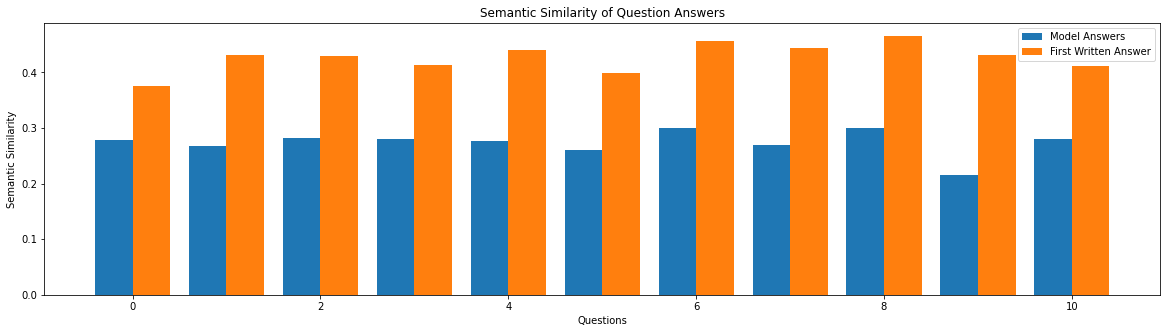

In [58]:
x_values = [q["Question"] for q in QA_data["Questions"]]
print(x_values)
model = [ModelAnsSim[a] for a in x_values]
written = [RealAnsSim[a] for a in x_values]

fig = plt.figure(figsize = (20, 5))

X_axis = np.arange(len(x_values))
plt.bar(X_axis - 0.2, model, 0.4, label = 'Model Answers')
plt.bar(X_axis + 0.2, written, 0.4,  label = 'First Written Answer')
plt.legend()
#plt.xticks(X_axis, x_values)

plt.xlabel("Questions")
plt.ylabel("Semantic Similarity")
plt.title("Semantic Similarity of Question Answers")
plt.show()